In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from tqdm.notebook import tqdm_notebook

%matplotlib inline

In [4]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install h2o

  Created wheel for h2o: filename=h2o-3.36.0.2-py2.py3-none-any.whl size=176112126 sha256=319323ea220fcb370f7d3565a45b461ce5745293a198c518fb1f6458b7961f00
  Stored in directory: c:\users\40100182\appdata\local\pip\cache\wheels\51\21\0c\746203762bf4493f01425b6574f85c2099881fa59228074d14
Successfully built h2o


In [5]:
import h2o
from h2o.automl import H2OAutoML

In [10]:
# reading the files
tqdm_notebook.pandas()

train = pd.read_csv('train.csv')
print (f"Rows: {train.shape[0]}, Columns: {train.shape[1]}")

test = pd.read_csv('test.csv')
print (f"Rows: {test.shape[0]}, Columns: {test.shape[1]}")

sample = pd.read_csv('sample_submission.csv')
print (f"Rows: {sample.shape[0]}, Columns: {sample.shape[1]}")

Rows: 40000, Columns: 15
Rows: 10000, Columns: 14
Rows: 10000, Columns: 2


In [11]:
train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.0,0.642286,0.856520,0.707073,0.002001,10.0,NaN,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,NaN,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.0,NaN,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.0,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.0,0.493017,NaN,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


In [12]:
# check for missing values
print("Percentage missing values in Train")
v1 = pd.DataFrame(data=dict(train.isna().sum()*100/train.shape[0]).items(), columns=['feature', '%missing_train'])
v2 = pd.DataFrame(data=dict(test.isna().sum()*100/test.shape[0]).items(), columns=['feature', '%missing_test'])

v1 = v1.merge(v2, on="feature", how="inner")
v1

Percentage missing values in Train


,feature,%missing_train,%missing_test
0,id,0.0000,0.00
1,song_duration_ms,10.2525,9.57
2,acousticness,9.9800,9.50
3,danceability,10.0650,9.76
4,energy,9.9375,10.55
5,instrumentalness,9.9625,10.00
6,key,10.1625,9.92
7,liveness,10.2150,10.06
8,loudness,9.8925,10.26
9,audio_mode,0.0000,0.00


In [14]:
# type of data

train.dtypes

id                    int64
song_duration_ms    float64
acousticness        float64
danceability        float64
energy              float64
instrumentalness    float64
key                 float64
liveness            float64
loudness            float64
audio_mode            int64
speechiness         float64
tempo               float64
time_signature        int64
audio_valence       float64
song_popularity       int64
dtype: object

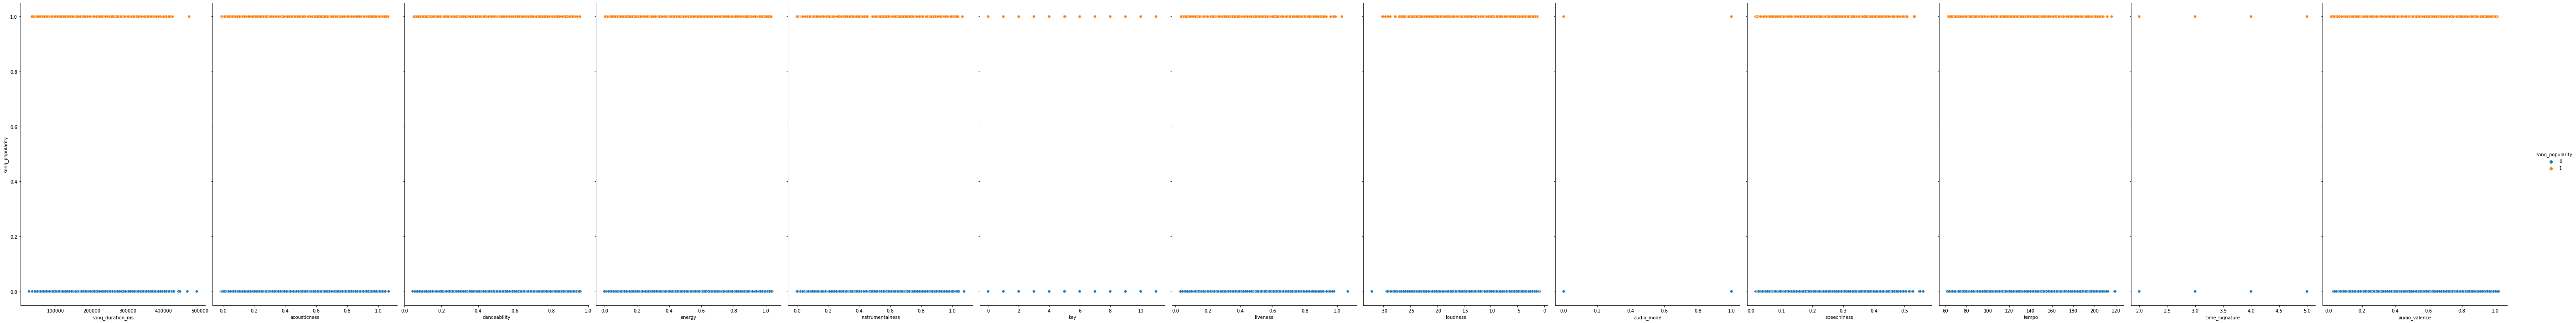

<Figure size 1800x1440 with 0 Axes>

In [15]:
pp = sns.pairplot(data=train,
                  y_vars=['song_popularity'],
                  x_vars=[x for x in train.columns if x not in ['id','song_popularity']],
                  hue='song_popularity', dropna=True,
                  height=10, aspect=0.6)
plt.figure(figsize=(25,20))
plt.show()

In [12]:
# Let's do a simple imputation using sklearn

vars_miss_values = ["song_duration_ms","acousticness","danceability","energy",
                    "instrumentalness","key","liveness","loudness"]


imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
imputer = imputer.fit(train[vars_miss_values])

train[vars_miss_values] = imputer.transform(train[vars_miss_values])
test[vars_miss_values] = imputer.transform(test[vars_miss_values])

train.head()

,id,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence,song_popularity
0,0,212990.000000,0.642286,0.856520,0.707073,0.002001,10.0,0.198514,-5.619088,0,0.082570,158.386236,4,0.734642,0
1,1,193165.847572,0.054866,0.733289,0.835545,0.000996,8.0,0.436428,-5.236965,1,0.127358,102.752988,3,0.711531,1
2,2,193213.000000,0.276404,0.188387,0.783524,-0.002694,5.0,0.170499,-4.951759,0,0.052282,178.685791,3,0.425536,0
3,3,249893.000000,0.488660,0.585234,0.552685,0.000608,0.0,0.094805,-7.893694,0,0.035618,128.715630,3,0.453597,0
4,4,165969.000000,0.493017,0.570951,0.740982,0.002033,10.0,0.094891,-2.684095,0,0.050746,121.928157,4,0.741311,0


<AxesSubplot:>

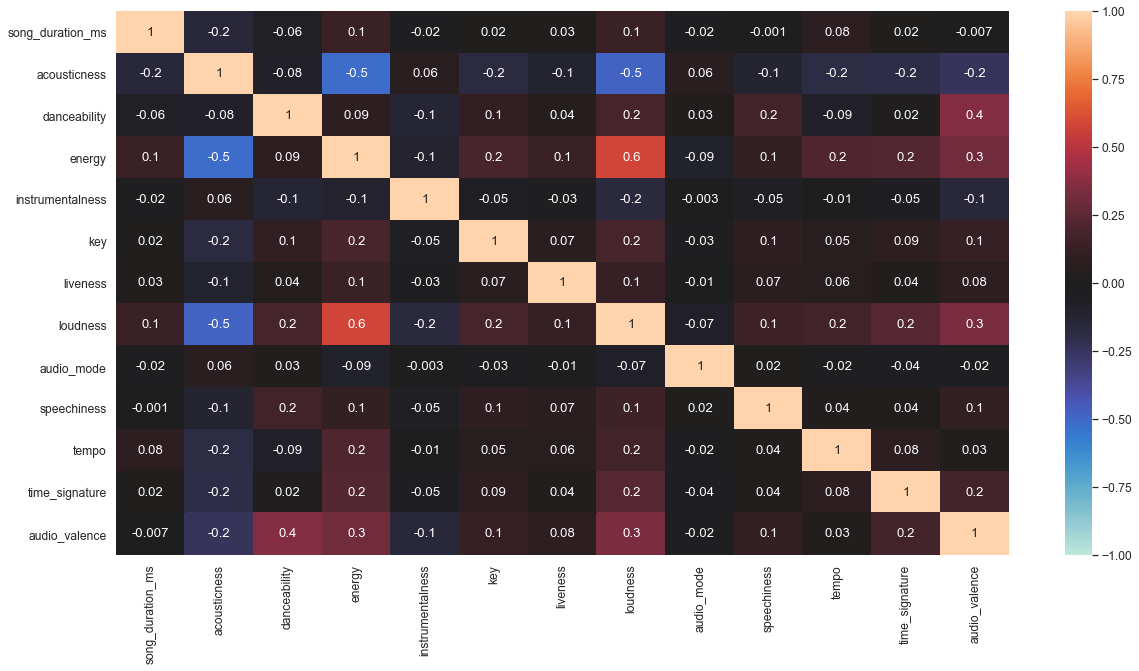

In [16]:
cols = [x for x in train.columns if x not in ['id','song_popularity']]
redu = train.loc[:, cols]

plt.figure(figsize=(20,10))
sns.set(font_scale=1.1)
sns.heatmap(redu.corr(), annot=True, fmt='.1g', vmin=-1, vmax=1, center=0)

In [ ]:
train =train.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

In [ ]:
print (df.shape)

train_ids = df.index[df.date1 <= '2021-04-30'].tolist()
test_ids = df.index[df.date1 > '2021-04-30'].tolist()

print (f"Length of the index series for train and test are {len(train_ids)} and {len(test_ids)}")
assert df.shape[0] == len(train_ids) + len(test_ids)


x = df[['client_id', 'sku', 'hl_shifted_1', 'last_ordered_days', 'exp_3',
        'ma_3', 'week', 'month', 'dayofweek', 'is_weekend', 
        'is_monthstart', 'is_monthend', 'daily_avg', 'wkend_avg', 
        'monthly_avg', 'weekly_avg']]


x_train2 = x.loc[train_ids, ]
y_train2 = df.loc[train_ids, 'hl']

x_test2 = x.loc[test_ids, ]
y_test2 = df.loc[test_ids, 'hl']

print (x_train2.shape, x_test2.shape, len(y_train2), len(y_test2))